# Preparação do ambiente

## Bibliotecas

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string

from os import path as osp
from pprint import pprint
from tabulate import tabulate

## Constantes e funções auxiliares

In [2]:
NULL_STRING = '#NULLO#'
FILE_ANUNCIOS = '../datasets/anuncios.parquet'

FILE_FISCAIS = '../datasets/label_issues/20240423/fiscais_to_label.xlsx'
FILE_SAMPLES = '../datasets/label_issues/20240423/samples.parquet'
FILE_ISSUES_TO_FISCALIZA = '../datasets/label_issues/20240423/issues_to_fiscaliza.txt'

In [3]:
def flatten_matrix(matrix):
    return [item for row in matrix for item in row]

In [4]:
def extract_amazon_images(row):
    imagens = []
    imagens.append(row['Imagem'].split()[0])
    imagens.extend(row['Imagens'].split())

    imagens = [imagem for imagem in imagens if imagem.startswith('http')]
    if len(imagens) >= 3:
        imagens = imagens[:3]
    elif len(imagens) == 2:
        imagens.extend([''])
    elif len(imagens) == 1:
        imagens.extend(['',''])
    else:
        imagens.extend(['','',''])

    return pd.Series(imagens)

def extract_amazon_desc(row):
    desc = '\n'.join(row)
    desc = desc.replace(NULL_STRING,' ')
    desc = re.sub('\s+', ' ', desc)
    return desc

In [5]:
def extract_magalu_images(row):
    imagens = []
    imagens.append(row['Imagem'].split()[0])
    imagens.extend(row['Imagens'].split(','))

    imagens = [imagem for imagem in imagens if imagem.startswith('http')]
    if len(imagens) >= 3:
        imagens = imagens[:3]
    elif len(imagens) == 2:
        imagens.extend([''])
    elif len(imagens) == 1:
        imagens.extend(['',''])
    else:
        imagens.extend(['','',''])

    return pd.Series(imagens)

In [6]:
def format_issue(row,remove_punct=False):
    nome,desc,img0,img1,img2 = row
    
    # remove null string
    desc = desc.replace(NULL_STRING,'')
    # remove punctiation from nome and desc
    if remove_punct:
        nome = nome.translate(str.maketrans('', '', string.punctuation))
        desc = desc.translate(str.maketrans('', '', string.punctuation))

    # remove ponto-e-vírgula e aspas duplas para evitar a 
    # identificação incorreta de campos ao importar para o redmine
    desc = desc.replace(';',',')
    desc = desc.replace('"',"''")
    # remove multiple linebrakes and spaces
    desc = re.sub('\n+','\n\n',desc)
    desc = re.sub('\s+',' ',desc)
    desc = desc.strip()
    
    img_css = '{max-width:250px; height:auto}'
    if len(img2) > 0:
        img_list = f'!{img_css}{img0}! !{img_css}{img1}! !{img_css}{img2}!'
    elif len(img1) > 0:
        img_list = f'!{img_css}{img0}! !{img_css}{img1}!'
    elif len(img0) > 0:
        img_list = f'!{img_css}{img0}!'
    else:
        img_list = ''
        
    if len(desc) >= 1:
        issue = f'h1. {nome}\n\n{desc}\n\n{img_list}'
    else:
        issue = f'h1. {nome}\n\n{img_list}'
    
    return issue.strip()

In [7]:
def plot_donut(labels,values,title,startangle=30):
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw=dict(aspect="equal"))
    
    wedges, texts = ax.pie(values, wedgeprops=dict(width=0.5), startangle=startangle)
    
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props,
              zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    
    ax.set_title(title)
    plt.show()

# Carga e prepação dos dados

In [8]:
if osp.exists(FILE_ANUNCIOS):
    df_anuncios = pd.read_parquet(FILE_ANUNCIOS)
df_anuncios.head(5)

,marketplace,link,nome,desc,img0,img1,img2
0,amazon,https://www.amazon.com.br/Especiais-Cinematic-...,Filtro de Lente de Efeitos Especiais Blue Stre...,Especificações: Modelo aplicável: este filtro ...,https://m.media-amazon.com/images/I/61ZdffRDj2...,https://m.media-amazon.com/images/I/51DeP4IE2F...,https://m.media-amazon.com/images/I/41w7kz5r4P...
1,amazon,https://www.amazon.com.br/Motores-Escova-Conju...,"Motores Sem Escova, 4 Conjuntos de Motores Sem...",1. Modelo de uso: Este motor sem escova de dro...,https://m.media-amazon.com/images/I/51aZmDncic...,https://m.media-amazon.com/images/I/31mER3G37I...,https://m.media-amazon.com/images/I/31jk4g-fUt...
2,amazon,https://www.amazon.com.br/Armazenamento-Protet...,"Bolsa de Armazenamento Protetora para Drone, C...",1. Excelente proteção: o case rígido do drone ...,https://m.media-amazon.com/images/I/612uWGXrp7...,https://m.media-amazon.com/images/I/41JfSjIxxR...,https://m.media-amazon.com/images/I/41CVth1dqO...
3,amazon,https://www.amazon.com.br/EQUSS-V-strom-Motoci...,EQUSS Para DUCATI DL650 DL1000 V-strom DL 650 ...,1. Material: liga de alumínio [Super Grip] - D...,https://m.media-amazon.com/images/I/51-m8iNiuL...,https://m.media-amazon.com/images/I/31VLMQCsxU...,https://m.media-amazon.com/images/I/31WjqM+BqB...
4,amazon,https://www.amazon.com.br/remote-control-brush...,"remote control car brushless motor servo kit,r...",,https://m.media-amazon.com/images/I/61Hzfl2r75...,https://m.media-amazon.com/images/I/41P1kyyx1l...,https://m.media-amazon.com/images/I/41I9plec-T...


╭───────────────┬──────────────╮
│ Marketplace   │   Quantidade │
├───────────────┼──────────────┤
│ amazon        │       143657 │
├───────────────┼──────────────┤
│ mercadolivre  │        54862 │
├───────────────┼──────────────┤
│ magalu        │        31647 │
╰───────────────┴──────────────╯


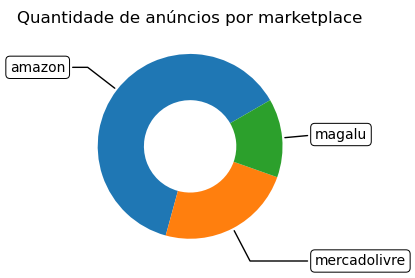

In [9]:
qt_anuncios = df_anuncios['marketplace'].value_counts()
labels, values = qt_anuncios.index, qt_anuncios.values

print(tabulate({'Marketplace': list(qt_anuncios.index), 'Quantidade': list(qt_anuncios.values)},headers="keys",intfmt=',',tablefmt='rounded_grid').replace(',','.'))
plot_donut(labels,values, 'Quantidade de anúncios por marketplace',startangle=30)

# Seleção da amostra

In [10]:
df_fiscais = pd.read_excel(FILE_FISCAIS)
df_fiscais

,Fiscal,Lotação,Login,Tarefas
0,Cesar Alexandre Parazi,FIGF2,parazi,512
1,Eduardo Renato Rocha Brandao,GR02,eduardo,1024
2,José Carlos da Silva,GR04FI1,jcsilva,1024
3,Marcelo Ricardo Loschi,GR04FI2,marcelol,1024
4,Sinval Martins Barbosa,GR04FI2,sinval,1024
5,Carlos Juliano Pott,GR05,pott,1024
6,Jose Luciano da Silva,GR06,jluciano,1024
7,Leandro Rodrigues Belo,GR07FI2,leandrorb,1024
8,Pedro de Barros,GR07FI2,pedro,1024
9,Ronan Carvalho Junior,GR07FI2,ronanj,1024


In [11]:
# lista e quantidade de fiscais
fiscais = df_fiscais.Login.to_list()
tarefas_fiscal = df_fiscais.Tarefas.to_list()

fiscais_amostra = []

for fiscal, n_tarefa in zip(fiscais,tarefas_fiscal):
    fiscais_amostra.extend([fiscal for i in range(n_tarefa)])
df_fiscais_amostra = pd.DataFrame(fiscais_amostra,columns=['Atribuído para'])

df_fiscais_amostra['Atribuído para'].value_counts()

Atribuído para
wesleychaves    1024
eduardo         1024
darlan          1024
marcosrg        1024
aeciom          1024
sebastiao       1024
williams        1024
romildo         1024
josias          1024
joaotavares     1024
josemarcelo     1024
hans            1024
ronanj          1024
pedro           1024
leandrorb       1024
jluciano        1024
pott            1024
sinval          1024
marcelol        1024
jcsilva         1024
thiagoalves      512
parazi           512
Name: count, dtype: int64

In [12]:
# seleção da amostras
n_samples, _ = df_fiscais_amostra.shape
df_fiscaliza = df_anuncios.sample(n_samples,random_state=2304)
df_fiscaliza = df_fiscaliza.reset_index(drop=True)

# título da última tarefa no Fiscaliza
# as novas terão numeração sequencial a partir desta
fiscaliza_last_issue = 00000000
format_title = lambda i: f'LABEL_PACP_2024_{str(i+1+fiscaliza_last_issue).zfill(8)}'

columns_to_issues = ['nome', 'desc', 'img0', 'img1', 'img2']

df_fiscaliza['Título'] = df_fiscaliza.index.map(format_title)
df_fiscaliza['Descrição'] = df_fiscaliza[columns_to_issues].apply(lambda row: format_issue(row),axis=1)

df_fiscaliza['Tipo'] = 'Rotulagem de Dados'
df_fiscaliza['Situação'] = 'Responder pesquisa'

df_fiscaliza['Data de início'] = '29/04/2024'
df_fiscaliza['Data limite'] = '31/05/2024'

df_fiscaliza = df_fiscaliza.join(df_fiscais_amostra)

df_fiscaliza.to_parquet(FILE_SAMPLES,index=False)

columns_to_issues = ['Tipo', 'Situação', 'Título', 'Descrição', 'Data de início', 'Data limite', 'Atribuído para']
df_fiscaliza[columns_to_issues].to_csv(FILE_ISSUES_TO_FISCALIZA,index=False,sep=';')

df_fiscaliza[columns_to_issues]

,Tipo,Situação,Título,Descrição,Data de início,Data limite,Atribuído para
0,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00000001,h1. Streaming Box S Tucson 2018 A 2022 Carplay...,29/04/2024,31/05/2024,parazi
1,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00000002,h1. Smartphone Motorola Moto G52 XT2221-1 Dual...,29/04/2024,31/05/2024,parazi
2,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00000003,h1. Notebook Dell Latitude 7490 I5 8ª Ger Ddr4...,29/04/2024,31/05/2024,parazi
3,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00000004,"h1. Mini rede sem fio, placa de rede sem fio U...",29/04/2024,31/05/2024,parazi
4,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00000005,"h1. Fone Bluetooth TWS Kaidi KD-771 - 5.1, Tou...",29/04/2024,31/05/2024,parazi
...,...,...,...,...,...,...,...
21499,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00021500,"h1. Alto-falante portátil externo,Alto-falante...",29/04/2024,31/05/2024,hans
21500,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00021501,"h1. Carregador de bateria 18650, caixa de banc...",29/04/2024,31/05/2024,hans
21501,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00021502,h1. Microfone Lapela Sem Fio Compatível Androi...,29/04/2024,31/05/2024,hans
21502,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00021503,"h1. AceFlows, Aceflows Earbuds, Aceflows Cryst...",29/04/2024,31/05/2024,hans


In [13]:
df_fiscaliza['Atribuído para'].value_counts()

Atribuído para
wesleychaves    1024
eduardo         1024
darlan          1024
marcosrg        1024
aeciom          1024
sebastiao       1024
williams        1024
romildo         1024
josias          1024
joaotavares     1024
josemarcelo     1024
hans            1024
ronanj          1024
pedro           1024
leandrorb       1024
jluciano        1024
pott            1024
sinval          1024
marcelol        1024
jcsilva         1024
thiagoalves      512
parazi           512
Name: count, dtype: int64

╭───────────────┬──────────────╮
│ Marketplace   │   Quantidade │
├───────────────┼──────────────┤
│ amazon        │        13377 │
├───────────────┼──────────────┤
│ mercadolivre  │         5239 │
├───────────────┼──────────────┤
│ magalu        │         2888 │
╰───────────────┴──────────────╯


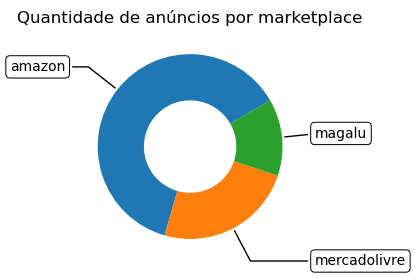

In [14]:
qt_anuncios = df_fiscaliza['marketplace'].value_counts()
labels, values = qt_anuncios.index, qt_anuncios.values

print(tabulate({'Marketplace': list(qt_anuncios.index), 'Quantidade': list(qt_anuncios.values)},headers="keys",intfmt=',',tablefmt='rounded_grid').replace(',','.'))
plot_donut(labels,values, 'Quantidade de anúncios por marketplace',startangle=30)